In [ ]:
# 1️⃣ Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2️⃣ Create a local fast workspace
!mkdir -p /content/data/splits

# 3️⃣ Copy your preprocessed dataset (.npy files)
#    Adjust the source path if your files are stored differently in Drive.
!cp -v "/content/drive/MyDrive/speakez/data/splits/X_train.npy" /content/data/splits/
!cp -v "/content/drive/MyDrive/speakez/data/splits/y_train.npy" /content/data/splits/
!cp -v "/content/drive/MyDrive/speakez/data/splits/X_val.npy"   /content/data/splits/
!cp -v "/content/drive/MyDrive/speakez/data/splits/y_val.npy"   /content/data/splits/
!cp -v "/content/drive/MyDrive/speakez/data/splits/X_test.npy"  /content/data/splits/
!cp -v "/content/drive/MyDrive/speakez/data/splits/y_test.npy"  /content/data/splits/

# 4️⃣ Confirm copy
!ls -lh /content/data/splits


'/content/drive/MyDrive/speakez/data/splits/X_train.npy' -> '/content/data/splits/X_train.npy'
'/content/drive/MyDrive/speakez/data/splits/y_train.npy' -> '/content/data/splits/y_train.npy'
'/content/drive/MyDrive/speakez/data/splits/X_val.npy' -> '/content/data/splits/X_val.npy'
'/content/drive/MyDrive/speakez/data/splits/y_val.npy' -> '/content/data/splits/y_val.npy'
'/content/drive/MyDrive/speakez/data/splits/X_test.npy' -> '/content/data/splits/X_test.npy'
'/content/drive/MyDrive/speakez/data/splits/y_test.npy' -> '/content/data/splits/y_test.npy'
total 36G
-rw------- 1 root root 5.4G Oct  5 04:47 X_test.npy
-rw------- 1 root root  26G Oct  5 04:43 X_train.npy
-rw------- 1 root root 5.4G Oct  5 04:45 X_val.npy
-rw------- 1 root root  52K Oct  5 04:47 y_test.npy
-rw------- 1 root root 239K Oct  5 04:43 y_train.npy
-rw------- 1 root root  52K Oct  5 04:45 y_val.npy


# SpeakEZ — Colab Training from Preprocessed NPY (ASL A–Z + SPACE + DEL + NOTHING)

This notebook trains directly from the preprocessed `.npy` arrays you generated locally.
It enforces consistent class order and adds a tiny overfit sanity test (must pass).


# Cell 2 — Setup & Environment

In [ ]:
import os, sys, platform, random
import numpy as np, json

import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
print("Python:", sys.version)
print("TF:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# Mixed precision (faster on T4/A100)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("Using mixed precision.")
except Exception as e:
    print("Mixed precision not enabled:", e)


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TF: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using mixed precision.


# Cell 3 — Paths & Config

In [ ]:
# Adjust these paths to where you uploaded the npy files in Colab
DATA_SPLITS_DIR = "/content/data/splits"   # e.g., after you copy from Drive to /content

X_train = np.load(os.path.join(DATA_SPLITS_DIR,"X_train.npy"), mmap_mode='r')
y_train = np.load(os.path.join(DATA_SPLITS_DIR,"y_train.npy"), mmap_mode='r')
X_val   = np.load(os.path.join(DATA_SPLITS_DIR,"X_val.npy"),   mmap_mode='r')
y_val   = np.load(os.path.join(DATA_SPLITS_DIR,"y_val.npy"),   mmap_mode='r')
X_test  = np.load(os.path.join(DATA_SPLITS_DIR,"X_test.npy"),  mmap_mode='r')
y_test  = np.load(os.path.join(DATA_SPLITS_DIR,"y_test.npy"),  mmap_mode='r')

print("train X:", X_train.shape, X_train.dtype, "min/max:", float(X_train.min()), float(X_train.max()))
print("train y:", y_train.shape, y_train.dtype, "labels:", int(y_train.min()), "→", int(y_train.max()))
print("val   X:", X_val.shape,   X_val.dtype)
print("val   y:", y_val.shape,   y_val.dtype)
print("test  X:", X_test.shape,  X_test.dtype)
print("test  y:", y_test.shape,  y_test.dtype)

# Expect: X_*=(N, 192,192,3), float32 in [0,1]; y_* ints in [0,28]

# IMPORTANT: Match your preprocessing log — 29 classes with 'DEL' (not 'DELETE'), 192×192 images
CLASSES = [
    'A','B','C','D','E','F','G','H','I','J','K','L','M',
    'N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
    'SPACE','DEL','NOTHING'
]
NUM_CLASSES = len(CLASSES)
assert NUM_CLASSES == 29

IMAGE_SIZE_SRC = (192,192)      # as preprocessed
IMAGE_SIZE_TRAIN = (128,128)    # keep; set to (128,128) if you want faster training
BATCH_SIZE = 64
SEED = 1234


train X: (60899, 192, 192, 3) float32 min/max: 0.0 1.0
train y: (60899,) int32 labels: 0 → 28
val   X: (13050, 192, 192, 3) float32
val   y: (13050,) int32
test  X: (13051, 192, 192, 3) float32
test  y: (13051,) int32


In [ ]:
# Optional ONNX export
# !pip install -q tf2onnx
# import tf2onnx
# spec = (tf.TensorSpec((None, 192, 192, 3), tf.float32, name="input"),)
# onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
# with open(os.path.join(SAVE_DIR, "asl_baseline_cnn_192.onnx"), "wb") as f:
#     f.write(onnx_model.SerializeToString())
# print("Exported ONNX.")


# Option 2 .. still crashing

Cell — Verify shapes/dtypes (fast, no full load) (Duplicate Cell#3)

In [ ]:
import numpy as np, os, json

DATA_SPLITS_DIR = "/content/data/splits"

X_train = np.load(os.path.join(DATA_SPLITS_DIR,"X_train.npy"), mmap_mode='r')
y_train = np.load(os.path.join(DATA_SPLITS_DIR,"y_train.npy"), mmap_mode='r')
X_val   = np.load(os.path.join(DATA_SPLITS_DIR,"X_val.npy"),   mmap_mode='r')
y_val   = np.load(os.path.join(DATA_SPLITS_DIR,"y_val.npy"),   mmap_mode='r')
X_test  = np.load(os.path.join(DATA_SPLITS_DIR,"X_test.npy"),  mmap_mode='r')
y_test  = np.load(os.path.join(DATA_SPLITS_DIR,"y_test.npy"),  mmap_mode='r')

print("train X:", X_train.shape, X_train.dtype, "min/max:", float(X_train.min()), float(X_train.max()))
print("train y:", y_train.shape, y_train.dtype, "labels:", int(y_train.min()), "→", int(y_train.max()))
print("val   X:", X_val.shape,   X_val.dtype)
print("val   y:", y_val.shape,   y_val.dtype)
print("test  X:", X_test.shape,  X_test.dtype)
print("test  y:", y_test.shape,  y_test.dtype)

# Expect: X_*=(N, 192,192,3), float32 in [0,1]; y_* ints in [0,28]


train X: (60899, 192, 192, 3) float32 min/max: 0.0 1.0
train y: (60899,) int32 labels: 0 → 28
val   X: (13050, 192, 192, 3) float32
val   y: (13050,) int32
test  X: (13051, 192, 192, 3) float32
test  y: (13051,) int32


# New Cell — Visual sanity check (NPY/memmap version)

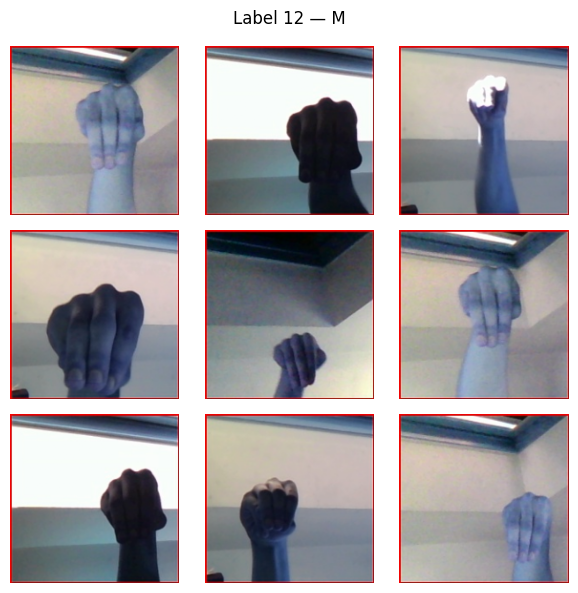

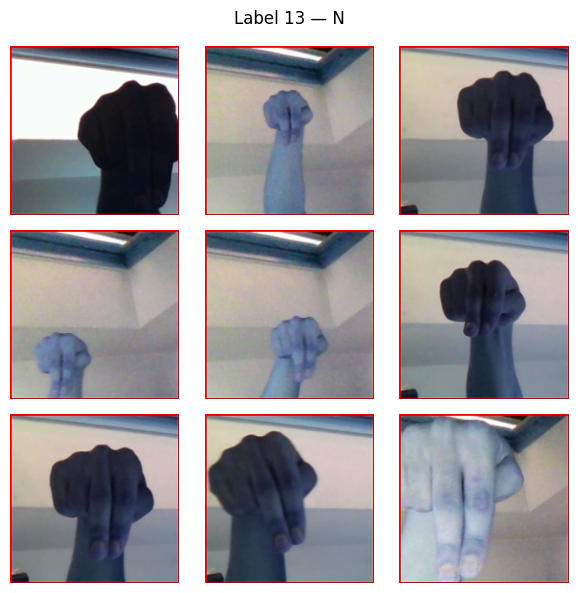

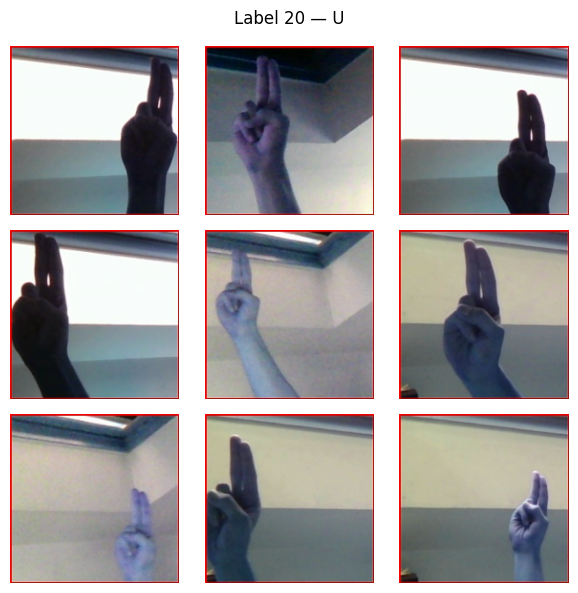

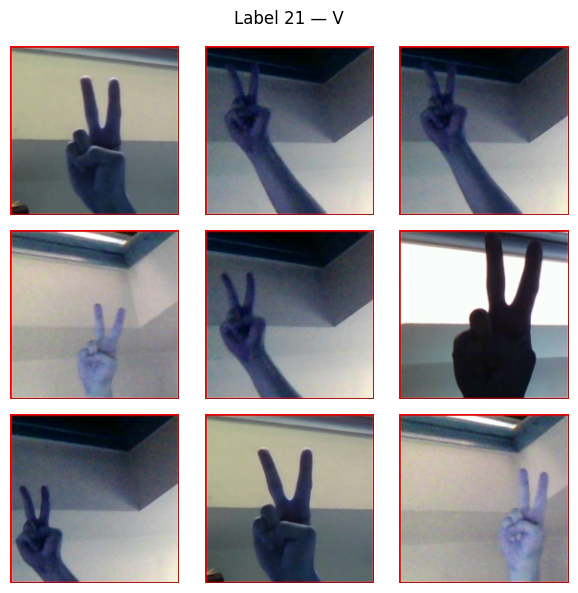

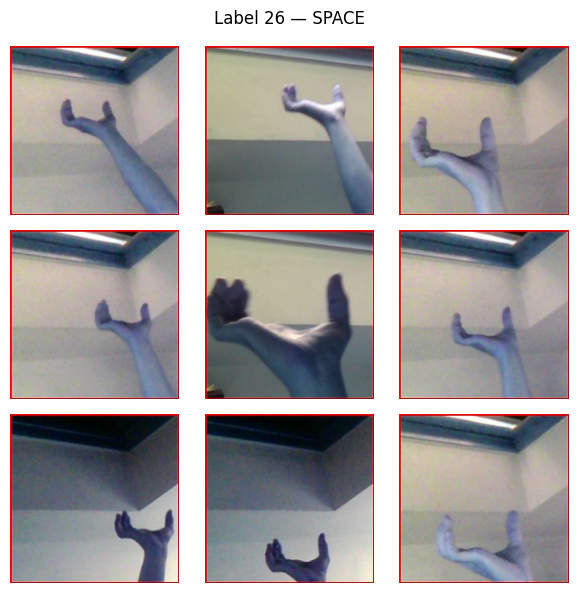

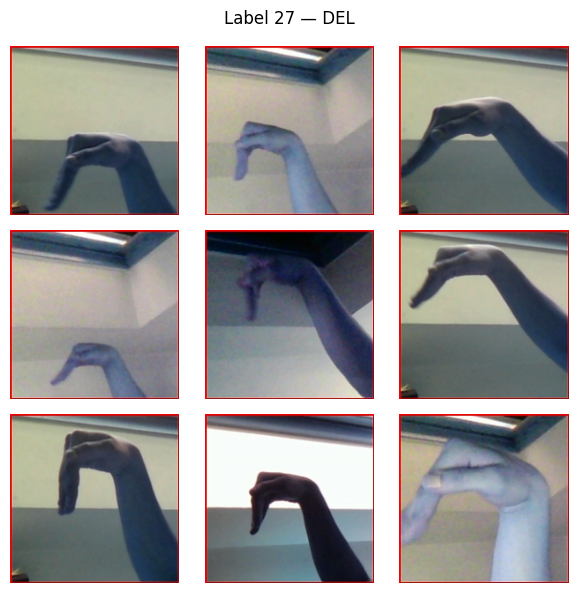

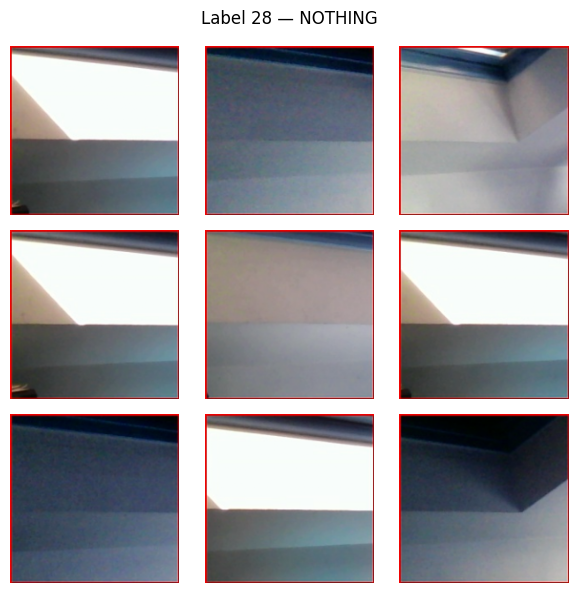

Adjacent same-label fraction (train): 0.03303885185063549


In [ ]:
# Run this AFTER you loaded X_train, y_train from .npy (mmap_mode='r')
import numpy as np
import matplotlib.pyplot as plt

# Must match your label IDs used during preprocessing
CLASSES = [
    'A','B','C','D','E','F','G','H','I','J','K','L','M',
    'N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
    'SPACE','DEL','NOTHING'
]

def show_samples_for_label(X, y, label_id, n=9):
    idx = np.where(y == label_id)[0]
    if len(idx) == 0:
        print(f"No samples for label {label_id} ({CLASSES[label_id]})")
        return
    pick = np.random.choice(idx, min(n, len(idx)), replace=False)
    imgs = X[pick]  # loads only the chosen images into RAM
    plt.figure(figsize=(6,6))
    for i, im in enumerate(imgs, 1):
        plt.subplot(3,3,i); plt.imshow(im); plt.axis('off')
    plt.suptitle(f"Label {label_id} — {CLASSES[label_id]}")
    plt.tight_layout()
    plt.show()

# Check a few tricky pairs + the command classes
for lid in [12,13,20,21,26,27,28]:   # M,N,U,V, SPACE, DEL, NOTHING
    show_samples_for_label(X_train, y_train, lid, n=9)

# Optional quick heuristic: are X and y catastrophically mispaired?
runs = np.mean(y_train[1:] == y_train[:-1])
print("Adjacent same-label fraction (train):", runs)


Cell — Streaming tf.data from memmap (no RAM blow-ups)

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

IMAGE_SIZE_SRC = (192,192)      # as preprocessed
IMAGE_SIZE_TRAIN = (128,128)    # keep; set to (128,128) if you want faster training
BATCH_SIZE = 64
SEED = 1234
NUM_CLASSES = 29

def make_index_ds(n, training=True, seed=SEED):
    ds = tf.data.Dataset.from_tensor_slices(tf.range(n, dtype=tf.int64))
    if training:
        ds = ds.shuffle(8192, seed=seed, reshuffle_each_iteration=True)
    return ds

def np_get_example(idx, split="train"):
    # idx: scalar numpy int64
    if split == "train":
        x, y = X_train[int(idx)], y_train[int(idx)]
    elif split == "val":
        x, y = X_val[int(idx)],   y_val[int(idx)]
    else:
        x, y = X_test[int(idx)],  y_test[int(idx)]
    return x, y

def tf_get_example(idx, split):
    x, y = tf.py_function(
        func=lambda j: np_get_example(j.numpy(), split=split),
        inp=[idx],
        Tout=[tf.float32, tf.int64]
    )
    x.set_shape((*IMAGE_SIZE_SRC, 3))
    y.set_shape(())
    return x, tf.cast(y, tf.int32)

def preprocess(x, y):
    # X already in [0,1]; enforce dtype and optional resize
    x = tf.cast(x, tf.float32)
    if IMAGE_SIZE_TRAIN != IMAGE_SIZE_SRC:
        x = tf.image.resize(x, IMAGE_SIZE_TRAIN, method='bilinear')
    return x, y

# light aug only; comment out initially if you want a clean start
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="light_aug")

def make_ds(n, split, training=True, batch_size=BATCH_SIZE):
    ds = make_index_ds(n, training=training)
    ds = ds.map(lambda i: tf_get_example(i, split), num_parallel_calls=AUTOTUNE)
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    #if training:
        #ds = ds.map(lambda x,y: (augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(len(X_train), split="train", training=True)
val_ds   = make_ds(len(X_val),   split="val",   training=False)
test_ds  = make_ds(len(X_test),  split="test",  training=False)

for xb, yb in train_ds.take(1):
    print("Batch:", xb.shape, yb.shape, xb.dtype, yb.dtype)


Batch: (64, 128, 128, 3) (64,) <dtype: 'float32'> <dtype: 'int32'>


Cell — Tiny overfit sanity test (uses a small materialized slice)

In [ ]:
# Materialize a tiny subset (e.g., 192 samples) to prove learning works.
def take_n_from_ds(ds, n=192):
    xs, ys = [], []
    for x, y in ds.unbatch().take(n):
        xs.append(x)
        ys.append(y)
    return tf.stack(xs), tf.stack(ys)

X_small, y_small = take_n_from_ds(train_ds, n=192)
print("tiny:", X_small.shape, y_small.shape)

from tensorflow.keras import layers, models

def tiny_cnn(input_shape=(128,128,3), num_classes=NUM_CLASSES):
    inputs = layers.Input(input_shape)
    x = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

tiny = tiny_cnn()
tiny.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

_ = tiny.fit(X_small, y_small, epochs=60, batch_size=32, validation_split=0.2, verbose=2)
# Expect train acc ~100% if labels/pipeline are correct.


tiny: (192, 128, 128, 3) (192,)
Epoch 1/60
5/5 - 16s - 3s/step - accuracy: 0.0523 - loss: 3.5435 - val_accuracy: 0.0256 - val_loss: 3.6790
Epoch 2/60
5/5 - 0s - 28ms/step - accuracy: 0.0327 - loss: 3.5337 - val_accuracy: 0.0256 - val_loss: 3.6914
Epoch 3/60
5/5 - 0s - 28ms/step - accuracy: 0.0458 - loss: 3.4443 - val_accuracy: 0.0256 - val_loss: 3.6306
Epoch 4/60
5/5 - 0s - 26ms/step - accuracy: 0.0392 - loss: 3.3968 - val_accuracy: 0.0256 - val_loss: 3.5632
Epoch 5/60
5/5 - 0s - 27ms/step - accuracy: 0.0980 - loss: 3.3211 - val_accuracy: 0.0256 - val_loss: 3.5255
Epoch 6/60
5/5 - 0s - 27ms/step - accuracy: 0.0850 - loss: 3.3076 - val_accuracy: 0.0256 - val_loss: 3.5144
Epoch 7/60
5/5 - 0s - 27ms/step - accuracy: 0.0654 - loss: 3.2577 - val_accuracy: 0.0000e+00 - val_loss: 3.5012
Epoch 8/60
5/5 - 0s - 26ms/step - accuracy: 0.0784 - loss: 3.2599 - val_accuracy: 0.0000e+00 - val_loss: 3.4882
Epoch 9/60
5/5 - 0s - 26ms/step - accuracy: 0.1111 - loss: 3.2181 - val_accuracy: 0.0000e+00 - va

Cell — Baseline CNN + training (mixed precision safe output)

In [ ]:
# ==== Build + Compile + Train (128×128) ====
import os, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models

# Derive NUM_CLASSES if not defined earlier
if "NUM_CLASSES" not in globals() or NUM_CLASSES is None:
    NUM_CLASSES = int(np.max(y_train)) + 1

INPUT_SHAPE = (128, 128, 3)   # must match your streaming resize

def baseline_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    inputs = layers.Input(input_shape)
    x = inputs
    for f in [32, 64, 128]:
        x = layers.Conv2D(f, 3, padding='same', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    # Keep output float32 under mixed precision so loss runs in fp32
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(inputs, outputs, name="baseline_cnn_128")

model = baseline_cnn()

# Metrics (include top-3 to monitor near-misses like U/V/SPACE, M/N)
metrics = [
    'accuracy',
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')
]

# Label smoothing helps similar-class confusion
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# Slight gradient clipping for stability
optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=1.0)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

# Ensure checkpoint directory exists
os.makedirs("/content/speakez_artifacts", exist_ok=True)

ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/speakez_artifacts/best_asl_baseline.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                         min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7,
                                     restore_best_weights=True, verbose=1),
    ckpt
]

# Class weights (capped to avoid extreme imbalance explosions)
unique, counts = np.unique(y_train, return_counts=True)  # y_train is memmap; fine
total = counts.sum()
raw_w = {int(k): float(total / (len(unique) * v)) for k, v in zip(unique, counts)}
med_w = float(np.median(list(raw_w.values())))
class_weight = {k: min(v, 3.0 * med_w) for k, v in raw_w.items()}  # cap at 3× median
print("Using class_weight (first 5):", list(class_weight.items())[:5], "...")

history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=class_weight,   # remove if it hurts stability
    verbose=2
)

# Save the final model as well
final_path = "/content/speakez_artifacts/asl_baseline_cnn_128_final.h5"
model.save(final_path)
print("Saved:", final_path)

Model: "baseline_cnn_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,885 (382.36 KB)

 Trainable params: 97,437 (380.61 KB)

 Non-trainable params: 448 (1.75 KB)

Using class_weight (first 5): [(0, 0.9999835796387521), (1, 0.9999835796387521), (2, 0.9999835796387521), (3, 0.9999835796387521), (4, 0.9999835796387521)] ...
Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.32866, saving model to /content/speakez_artifacts/best_asl_baseline.h5


952/952 - 358s - 376ms/step - accuracy: 0.3468 - loss: 2.2124 - top3_acc: 0.5818 - val_accuracy: 0.3287 - val_loss: 2.1109 - val_top3_acc: 0.5844 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_accuracy improved from 0.32866 to 0.49847, saving model to /content/speakez_artifacts/best_asl_baseline.h5


952/952 - 367s - 385ms/step - accuracy: 0.5914 - loss: 1.2943 - top3_acc: 0.8369 - val_accuracy: 0.4985 - val_loss: 1.7090 - val_top3_acc: 0.7465 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_accuracy improved from 0.49847 to 0.67678, saving model to /content/speakez_artifacts/best_asl_baseline.h5


952/952 - 383s - 403ms/step - accuracy: 0.7022 - loss: 0.9375 - top3_acc: 0.9087 - val_accuracy: 0.6768 - val_loss: 1.0565 - val_top3_acc: 0.8697 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.67678
952/952 - 385s - 405ms/step - accuracy: 0.7735 - loss: 0.7118 - top3_acc: 0.9442 - val_accuracy: 0.5141 - val_loss: 2.0527 - val_top3_acc: 0.7315 - learning_rate: 1.0000e-03
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.67678
952/952 - 384s - 403ms/step - accuracy: 0.8195 - loss: 0.5684 - top3_acc: 0.9644 - val_accuracy: 0.6752 - val_loss: 0.9563 - val_top3_acc: 0.8989 - learning_rate: 1.0000e-03
Epoch 6/30

Epoch 6: val_accuracy did not improve from 0.67678
952/952 - 378s - 397ms/step - accuracy: 0.8545 - loss: 0.4639 - top3_acc: 0.9766 - val_accuracy: 0.6762 - val_loss: 0.9654 - val_top3_acc: 0.9001 - learning_rate: 1.0000e-03
Epoch 7/30

Epoch 7: val_accuracy improved from 0.67678 to 0.73065, saving model to /content/speakez_artifacts/best

952/952 - 373s - 392ms/step - accuracy: 0.8812 - loss: 0.3821 - top3_acc: 0.9829 - val_accuracy: 0.7307 - val_loss: 0.7992 - val_top3_acc: 0.9259 - learning_rate: 1.0000e-03
Epoch 8/30

Epoch 8: val_accuracy improved from 0.73065 to 0.86797, saving model to /content/speakez_artifacts/best_asl_baseline.h5


952/952 - 377s - 397ms/step - accuracy: 0.9000 - loss: 0.3218 - top3_acc: 0.9880 - val_accuracy: 0.8680 - val_loss: 0.3683 - val_top3_acc: 0.9838 - learning_rate: 1.0000e-03
Epoch 9/30

Epoch 9: val_accuracy improved from 0.86797 to 0.94720, saving model to /content/speakez_artifacts/best_asl_baseline.h5


952/952 - 375s - 393ms/step - accuracy: 0.9195 - loss: 0.2697 - top3_acc: 0.9916 - val_accuracy: 0.9472 - val_loss: 0.1925 - val_top3_acc: 0.9935 - learning_rate: 1.0000e-03
Epoch 10/30

Epoch 10: val_accuracy did not improve from 0.94720
952/952 - 370s - 389ms/step - accuracy: 0.9306 - loss: 0.2313 - top3_acc: 0.9935 - val_accuracy: 0.9178 - val_loss: 0.2639 - val_top3_acc: 0.9879 - learning_rate: 1.0000e-03
Epoch 11/30

Epoch 11: val_accuracy did not improve from 0.94720
952/952 - 374s - 393ms/step - accuracy: 0.9411 - loss: 0.1999 - top3_acc: 0.9953 - val_accuracy: 0.7508 - val_loss: 0.7611 - val_top3_acc: 0.9495 - learning_rate: 1.0000e-03
Epoch 12/30

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_accuracy did not improve from 0.94720
952/952 - 375s - 394ms/step - accuracy: 0.9477 - loss: 0.1776 - top3_acc: 0.9960 - val_accuracy: 0.9336 - val_loss: 0.2012 - val_top3_acc: 0.9914 - learning_rate: 1.0000e-03
Epoch 13/30

Epoch 13: val_accu

952/952 - 375s - 394ms/step - accuracy: 0.9653 - loss: 0.1288 - top3_acc: 0.9981 - val_accuracy: 0.9910 - val_loss: 0.0604 - val_top3_acc: 0.9999 - learning_rate: 5.0000e-04
Epoch 14/30

Epoch 14: val_accuracy did not improve from 0.99096
952/952 - 372s - 391ms/step - accuracy: 0.9689 - loss: 0.1165 - top3_acc: 0.9984 - val_accuracy: 0.9764 - val_loss: 0.0903 - val_top3_acc: 0.9992 - learning_rate: 5.0000e-04
Epoch 15/30

Epoch 15: val_accuracy did not improve from 0.99096
952/952 - 371s - 390ms/step - accuracy: 0.9694 - loss: 0.1112 - top3_acc: 0.9984 - val_accuracy: 0.9741 - val_loss: 0.0865 - val_top3_acc: 0.9997 - learning_rate: 5.0000e-04
Epoch 16/30

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: val_accuracy did not improve from 0.99096
952/952 - 370s - 388ms/step - accuracy: 0.9732 - loss: 0.1011 - top3_acc: 0.9988 - val_accuracy: 0.9846 - val_loss: 0.0681 - val_top3_acc: 0.9992 - learning_rate: 5.0000e-04
Epoch 17/30

Epoch 17: val_accu

952/952 - 368s - 387ms/step - accuracy: 0.9790 - loss: 0.0816 - top3_acc: 0.9991 - val_accuracy: 0.9957 - val_loss: 0.0309 - val_top3_acc: 1.0000 - learning_rate: 2.5000e-04
Epoch 19/30

Epoch 19: val_accuracy did not improve from 0.99571
952/952 - 367s - 385ms/step - accuracy: 0.9795 - loss: 0.0776 - top3_acc: 0.9994 - val_accuracy: 0.9936 - val_loss: 0.0413 - val_top3_acc: 0.9995 - learning_rate: 2.5000e-04
Epoch 20/30

Epoch 20: val_accuracy did not improve from 0.99571
952/952 - 363s - 382ms/step - accuracy: 0.9811 - loss: 0.0749 - top3_acc: 0.9993 - val_accuracy: 0.9916 - val_loss: 0.0485 - val_top3_acc: 1.0000 - learning_rate: 2.5000e-04
Epoch 21/30

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 21: val_accuracy did not improve from 0.99571
952/952 - 367s - 385ms/step - accuracy: 0.9815 - loss: 0.0710 - top3_acc: 0.9993 - val_accuracy: 0.9877 - val_loss: 0.0531 - val_top3_acc: 0.9989 - learning_rate: 2.5000e-04
Epoch 22/30

Epoch 22: val_accu

952/952 - 366s - 385ms/step - accuracy: 0.9844 - loss: 0.0635 - top3_acc: 0.9996 - val_accuracy: 0.9982 - val_loss: 0.0219 - val_top3_acc: 1.0000 - learning_rate: 1.2500e-04
Epoch 23/30

Epoch 23: val_accuracy did not improve from 0.99816
952/952 - 367s - 386ms/step - accuracy: 0.9855 - loss: 0.0609 - top3_acc: 0.9996 - val_accuracy: 0.9969 - val_loss: 0.0292 - val_top3_acc: 1.0000 - learning_rate: 1.2500e-04
Epoch 24/30

Epoch 24: val_accuracy improved from 0.99816 to 0.99824, saving model to /content/speakez_artifacts/best_asl_baseline.h5


952/952 - 370s - 388ms/step - accuracy: 0.9857 - loss: 0.0596 - top3_acc: 0.9995 - val_accuracy: 0.9982 - val_loss: 0.0202 - val_top3_acc: 1.0000 - learning_rate: 1.2500e-04
Epoch 25/30

Epoch 25: val_accuracy did not improve from 0.99824
952/952 - 365s - 384ms/step - accuracy: 0.9863 - loss: 0.0587 - top3_acc: 0.9996 - val_accuracy: 0.9960 - val_loss: 0.0256 - val_top3_acc: 0.9998 - learning_rate: 1.2500e-04
Epoch 26/30

Epoch 26: val_accuracy improved from 0.99824 to 0.99839, saving model to /content/speakez_artifacts/best_asl_baseline.h5


952/952 - 363s - 381ms/step - accuracy: 0.9863 - loss: 0.0586 - top3_acc: 0.9996 - val_accuracy: 0.9984 - val_loss: 0.0201 - val_top3_acc: 1.0000 - learning_rate: 1.2500e-04
Epoch 27/30

Epoch 27: val_accuracy improved from 0.99839 to 0.99885, saving model to /content/speakez_artifacts/best_asl_baseline.h5


952/952 - 369s - 388ms/step - accuracy: 0.9867 - loss: 0.0559 - top3_acc: 0.9997 - val_accuracy: 0.9989 - val_loss: 0.0198 - val_top3_acc: 1.0000 - learning_rate: 1.2500e-04
Epoch 28/30

Epoch 28: val_accuracy did not improve from 0.99885
952/952 - 367s - 386ms/step - accuracy: 0.9867 - loss: 0.0548 - top3_acc: 0.9997 - val_accuracy: 0.9982 - val_loss: 0.0192 - val_top3_acc: 1.0000 - learning_rate: 1.2500e-04
Epoch 29/30

Epoch 29: val_accuracy did not improve from 0.99885
952/952 - 366s - 384ms/step - accuracy: 0.9867 - loss: 0.0551 - top3_acc: 0.9997 - val_accuracy: 0.9982 - val_loss: 0.0202 - val_top3_acc: 1.0000 - learning_rate: 1.2500e-04
Epoch 30/30

Epoch 30: val_accuracy did not improve from 0.99885
952/952 - 364s - 382ms/step - accuracy: 0.9873 - loss: 0.0529 - top3_acc: 0.9996 - val_accuracy: 0.9979 - val_loss: 0.0187 - val_top3_acc: 1.0000 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 27.


Saved: /content/speakez_artifacts/asl_baseline_cnn_128_final.h5


Load the best checkpoint & evaluate (val + test)

Loaded: /content/speakez_artifacts/best_asl_baseline.h5

Validation metrics:
204/204 - 37s - 182ms/step - accuracy: 0.9989 - loss: 0.0198 - top3_acc: 1.0000

Test metrics:
204/204 - 39s - 193ms/step - accuracy: 0.9989 - loss: 0.0187 - top3_acc: 1.0000

Classification Report (Test):
              precision    recall  f1-score   support

           A     0.9956    1.0000    0.9978       450
           B     1.0000    0.9956    0.9978       450
           C     1.0000    1.0000    1.0000       450
           D     1.0000    1.0000    1.0000       450
           E     1.0000    1.0000    1.0000       450
           F     1.0000    1.0000    1.0000       450
           G     0.9978    0.9978    0.9978       451
           H     1.0000    1.0000    1.0000       450
           I     1.0000    1.0000    1.0000       450
           J     0.9978    1.0000    0.9989       450
           K     0.9978    1.0000    0.9989       450
           L     1.0000    1.0000    1.0000       450
           M  

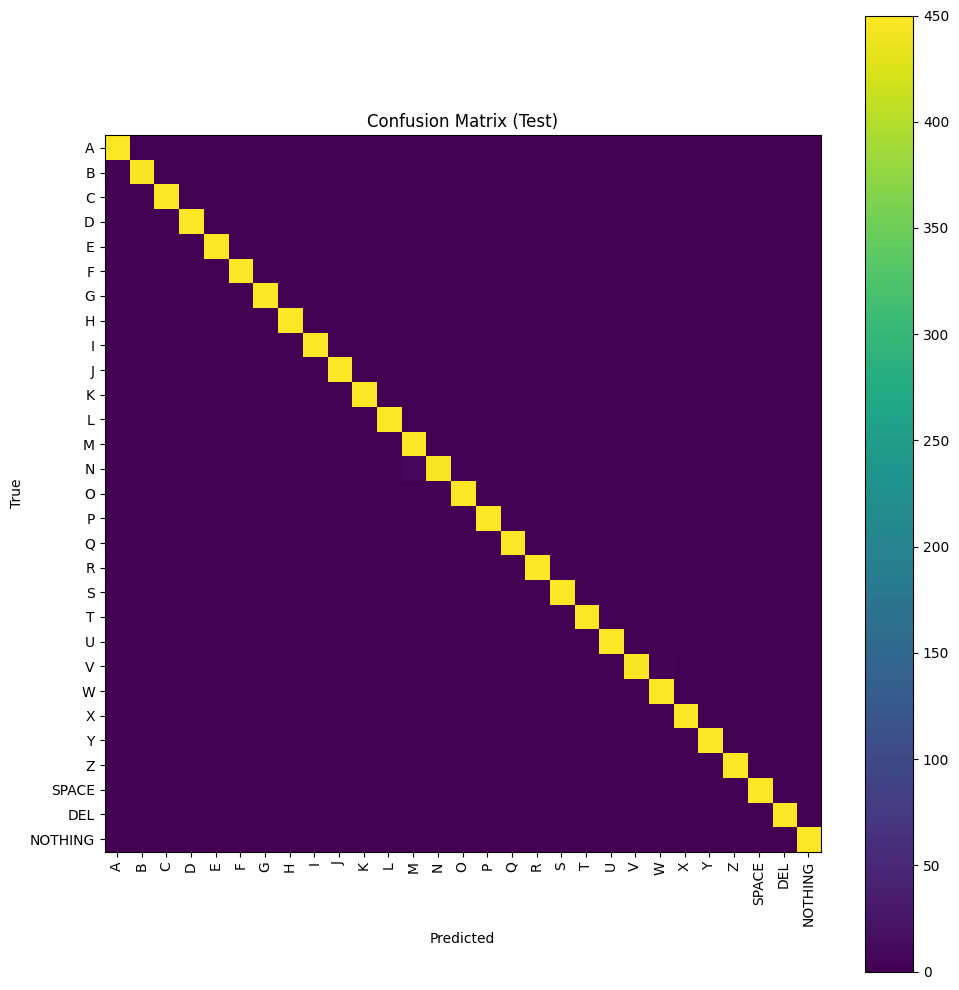

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

CLASSES = [
    'A','B','C','D','E','F','G','H','I','J','K','L','M',
    'N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
    'SPACE','DEL','NOTHING'
]

best_path = "/content/speakez_artifacts/best_asl_baseline.h5"
best = tf.keras.models.load_model(best_path)
print("Loaded:", best_path)

print("\nValidation metrics:")
best.evaluate(val_ds, verbose=2)

print("\nTest metrics:")
best.evaluate(test_ds, verbose=2)

# Detailed report on test set
y_true, y_pred = [], []
for xb, yb in test_ds:
    y_true.append(yb.numpy())
    probs = best.predict(xb, verbose=0)
    y_pred.append(np.argmax(probs, axis=1))
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print("\nClassification Report (Test):")
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Test)')
plt.colorbar()
ticks = np.arange(len(CLASSES))
plt.xticks(ticks, CLASSES, rotation=90); plt.yticks(ticks, CLASSES)
plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


Save in modern Keras format + keep H5 for compatibility

In [ ]:
import os
save_dir = "/content/speakez_artifacts"
os.makedirs(save_dir, exist_ok=True)

keras_path = os.path.join(save_dir, "asl_baseline_best.keras")
best.save(keras_path)   # native format (recommended)
print("Saved:", keras_path)

# (Optional) keep the H5 you already have


Saved: /content/speakez_artifacts/asl_baseline_best.keras


Export to ONNX for your web UI

In [ ]:
import tensorflow as tf, os
import numpy as np
best = tf.keras.models.load_model("/content/speakez_artifacts/asl_baseline_cnn_128_final.h5")

best.save("/content/speakez_artifacts/asl_baseline_best_128.keras")
print("Saved:", "/content/speakez_artifacts/asl_baseline_best_128.keras")

# ONNX export
!pip -q install tf2onnx
import tf2onnx
spec = (tf.TensorSpec((None, 128, 128, 3), tf.float32, name="input"),)
onnx_model, _ = tf2onnx.convert.from_keras(best, input_signature=spec, opset=13)
with open("/content/speakez_artifacts/asl_baseline_best_128.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
print("Saved:", "/content/speakez_artifacts/asl_baseline_best_128.onnx")



Saved: /content/speakez_artifacts/asl_baseline_best_128.keras


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7829aca411c0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


Saved: /content/speakez_artifacts/asl_baseline_best_128.onnx


Save labels.json (must match class order used)

In [ ]:
import json, os
labels_path = "/content/speakez_artifacts/labels.json"
with open(labels_path, "w") as f:
    json.dump(CLASSES, f, indent=2)
print("Saved:", labels_path)

import json, os
os.makedirs("/content/speakez_artifacts", exist_ok=True)
with open("/content/speakez_artifacts/history.json", "w") as f:
    json.dump(history.history, f)
print("Saved → /content/speakez_artifacts/history.json")



Saved: /content/speakez_artifacts/labels.json
Saved → /content/speakez_artifacts/history.json


Simple inference smoothing (ready to port to UI)

In [ ]:
from collections import deque
import numpy as np

class TemporalSmoother:
    def __init__(self, k=7):
        self.k = k
        self.buf = deque(maxlen=k)

    def update(self, probs):
        self.buf.append(np.argmax(probs))
        # majority vote
        vals, counts = np.unique(self.buf, return_counts=True)
        return int(vals[np.argmax(counts)])

# Example with a batch of frame probs (probs_batch: [T, 29])
# smoother = TemporalSmoother(k=7)
# for p in probs_batch:
#     pred = smoother.update(p)
#     print(CLASSES[pred])


# Quick curve plot cell (run after training)

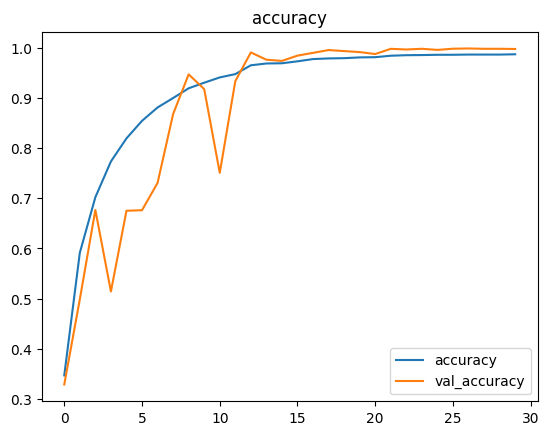

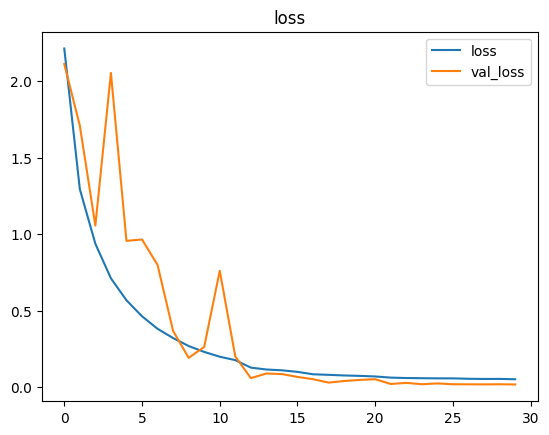

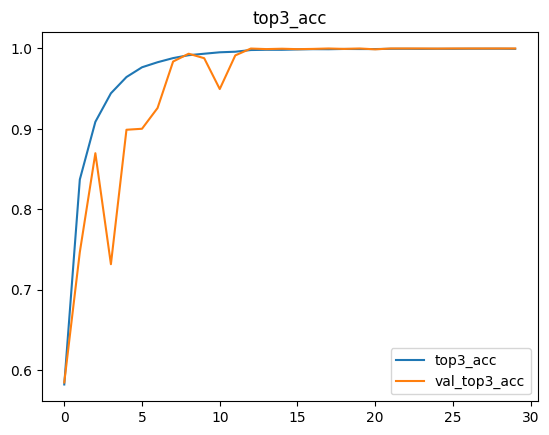

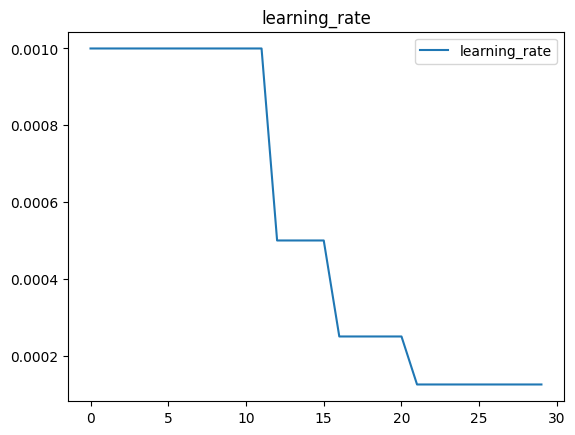

In [ ]:
import matplotlib.pyplot as plt
h = history.history
for k in [k for k in h.keys() if not k.startswith('val_')]:
    plt.figure(); plt.plot(h[k], label=k)
    v = 'val_'+k
    if v in h: plt.plot(h[v], label=v)
    plt.title(k); plt.legend(); plt.show()


In [ ]:

import os, json, numpy as np, tensorflow as tf

# Where to write outputs
ARTIFACTS_DIR = "/content/speakez_artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Path to best model (from your training callbacks)
BEST_MODEL_PATH = os.path.join(ARTIFACTS_DIR, "best_asl_baseline.h5")  # or .keras if you saved that

# Class list (must match training exactly)
CLASSES = [
    'A','B','C','D','E','F','G','H','I','J','K','L','M',
    'N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
    'SPACE','DEL','NOTHING'
]
NUM_CLASSES = len(CLASSES)

# Option A: Use existing datasets already in memory (train_ds/val_ds/test_ds)
USE_EXISTING_DS = 'test_ds' in globals()

# Option B: Rebuild val/test from .npy splits (set this if not using A)
DATA_SPLITS_DIR = "/content/data/splits"   # change if needed
IMAGE_SIZE_SRC = (192,192)
IMAGE_SIZE_TRAIN = (128,128)               # should match model input

print("Artifacts dir:", ARTIFACTS_DIR)
print("Model path:", BEST_MODEL_PATH)
print("Use existing datasets:", USE_EXISTING_DS)


Artifacts dir: /content/speakez_artifacts
Model path: /content/speakez_artifacts/best_asl_baseline.h5
Use existing datasets: True


In [ ]:

# In Colab this will work; no-op if already installed.
# Graphviz & pydot are needed for plot_model; sklearn/matplotlib for metrics/plots.
try:
    import pydot
except Exception:
    !apt-get -y install graphviz > /dev/null
    !pip -q install pydot

!pip -q install scikit-learn matplotlib


In [ ]:

from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load best model
model = tf.keras.models.load_model(BEST_MODEL_PATH)
model.summary()
input_res = model.input_shape[1:3]
print("Model expects resolution:", input_res)

# Build datasets from .npy if needed
if not USE_EXISTING_DS:
    AUTOTUNE = tf.data.AUTOTUNE

    def np_load(name):
        return np.load(os.path.join(DATA_SPLITS_DIR, name), mmap_mode='r')

    X_val = np_load("X_val.npy"); y_val = np_load("y_val.npy")
    X_test = np_load("X_test.npy"); y_test = np_load("y_test.npy")

    print("Val:", X_val.shape, y_val.shape, "Test:", X_test.shape, y_test.shape)

    def make_ds(X, y, batch=64):
        def cast_fn(x, y):
            x = tf.cast(x, tf.float32)
            if input_res != X.shape[1:3]:
                x = tf.image.resize(x, input_res, method='bilinear')
            y = tf.cast(y, tf.int32)
            return x, y
        ds = tf.data.Dataset.from_tensor_slices((X, y))
        ds = ds.map(cast_fn, num_parallel_calls=tf.data.AUTOTUNE)
        return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

    val_ds = make_ds(X_val, y_val)
    test_ds = make_ds(X_test, y_test)
else:
    # Reuse existing val_ds/test_ds from your training notebook
    pass


Model: "baseline_cnn_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,891 (382.40 KB)

 Trainable params: 97,437 (380.61 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 6 (36.00 B)

Model expects resolution: (128, 128)


In [ ]:

arch_path = os.path.join(ARTIFACTS_DIR, "model_architecture.png")
try:
    plot_model(model, to_file=arch_path, show_shapes=True, show_layer_names=True, dpi=120)
    print("Saved architecture graph ->", arch_path)
except Exception as e:
    print("plot_model failed:", e)


Saved architecture graph -> /content/speakez_artifacts/model_architecture.png


Saved training curves -> /content/speakez_artifacts/training_curves.png


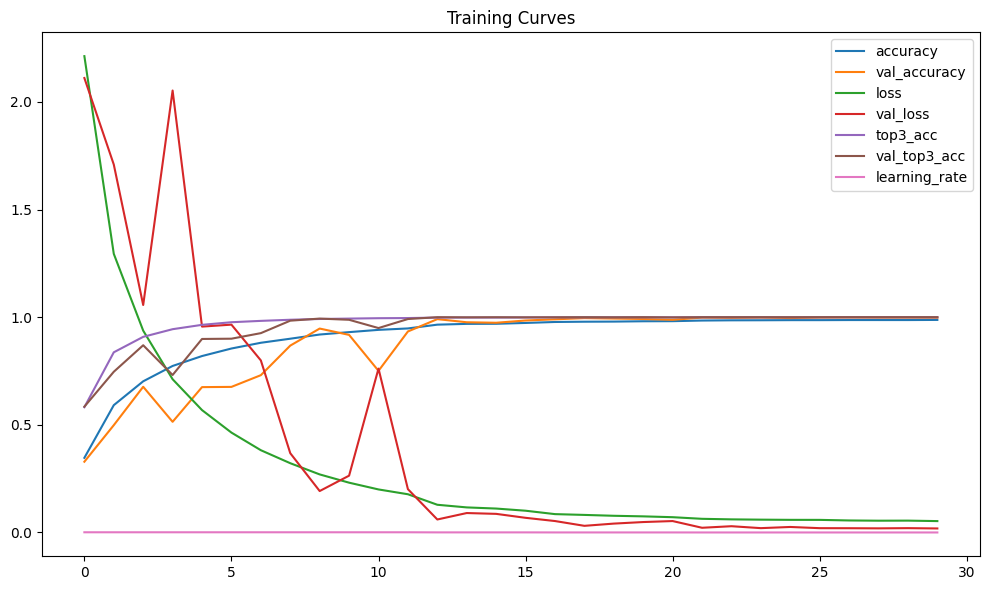

In [ ]:

curves_path = os.path.join(ARTIFACTS_DIR, "training_curves.png")
plt.figure(figsize=(10,6))

plotted = False
if 'history' in globals():
    h = history.history
    keys = [k for k in h.keys() if not k.startswith('val_')]
    for k in keys:
        plt.plot(h[k], label=k)
        vk = 'val_'+k
        if vk in h: plt.plot(h[vk], label=vk)
        plotted = True

if not plotted and os.path.exists(os.path.join(ARTIFACTS_DIR, "history.json")):
    with open(os.path.join(ARTIFACTS_DIR, "history.json")) as f:
        h = json.load(f)
    keys = [k for k in h.keys() if not k.startswith('val_')]
    for k in keys:
        plt.plot(h[k], label=k)
        vk = 'val_'+k
        if vk in h: plt.plot(h[vk], label=vk)
        plotted = True

if plotted:
    plt.title("Training Curves")
    plt.legend()
    plt.tight_layout()
    plt.savefig(curves_path, dpi=150)
    print("Saved training curves ->", curves_path)
else:
    plt.close()
    print("No history found in memory or artifacts; skip curves. If you have `history`, save with:")
    print("  import json; json.dump(history.history, open('/content/speakez_artifacts/history.json','w'))")


In [ ]:

cm_path = os.path.join(ARTIFACTS_DIR, "confusion_matrix.png")
report_path = os.path.join(ARTIFACTS_DIR, "classification_report.txt")

# Evaluate
print("\nEval (val):")
try:
    model.evaluate(val_ds, verbose=2)
except Exception as e:
    print("Val eval skipped:", e)

print("\nEval (test):")
try:
    model.evaluate(test_ds, verbose=2)
except Exception as e:
    print("Test eval skipped:", e)

# Predict on test to build CM and report
try:
    y_true, y_pred = [], []
    for xb, yb in test_ds:
        y_true.append(yb.numpy())
        pr = model.predict(xb, verbose=0)
        y_pred.append(np.argmax(pr, axis=1))
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix (Test)')
    plt.colorbar()
    ticks = np.arange(NUM_CLASSES)
    plt.xticks(ticks, CLASSES, rotation=90); plt.yticks(ticks, CLASSES)
    plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.savefig(cm_path, dpi=150)
    plt.close(fig)
    print("Saved confusion matrix ->", cm_path)

    rep = classification_report(y_true, y_pred, target_names=CLASSES, digits=4)
    with open(report_path, "w") as f:
        f.write(rep)
    print("Saved classification report ->", report_path)
except Exception as e:
    print("Skipping CM/report:", e)



Eval (val):
204/204 - 43s - 209ms/step - accuracy: 0.9989 - loss: 0.0198 - top3_acc: 1.0000

Eval (test):
204/204 - 37s - 183ms/step - accuracy: 0.9989 - loss: 0.0187 - top3_acc: 1.0000
Saved confusion matrix -> /content/speakez_artifacts/confusion_matrix.png
Saved classification report -> /content/speakez_artifacts/classification_report.txt


In [ ]:

report_md = f"""
# SpeakEZ — ASL A–Z Baseline Model Report

**Model:** Baseline CNN (32→64→128) + BN + ReLU + GlobalAvgPool + Dense
**Input Resolution:** {model.input_shape[1]}×{model.input_shape[2]}×{model.input_shape[3]}
**Parameters:** {model.count_params():,}

## 1. Architecture
![Model Architecture](model_architecture.png)

## 2. Training Curves
If trained in this runtime, curves are below; otherwise save `history.json` to artifacts and re-run this notebook.
![Training Curves](training_curves.png)

## 3. Validation/Test Performance
See printed metrics above. Detailed per-class metrics are in `classification_report.txt`.

## 4. Confusion Matrix (Test)
![Confusion Matrix](confusion_matrix.png)

## 5. Notes
- Similar-sign pairs (M↔N, U↔V↔SPACE) may show clustered confusions.
- Label smoothing (ε=0.05) and temporal smoothing at inference are applied/encouraged.
- Use `/content/speakez_artifacts/labels.json` for consistent downstream mapping.
"""

md_path = os.path.join(ARTIFACTS_DIR, "SpeakEZ_Model_Report.md")
with open(md_path, "w", encoding="utf-8") as f:
    f.write(report_md)

print("Saved report ->", md_path)
print("Artifacts:", os.listdir(ARTIFACTS_DIR))


Saved report -> /content/speakez_artifacts/SpeakEZ_Model_Report.md
Artifacts: ['asl_baseline_cnn_128_final.h5', 'SpeakEZ_Model_Report.md', 'best_asl_baseline.h5', 'classification_report.txt', 'asl_baseline_cnn_192.h5', 'training_curves.png', 'model_architecture.png', 'confusion_matrix.png']


# Quick sanity checks (run now)

In [ ]:
# Fast duplicate check by hashing exact image bytes (works with your preprocessed NPYs)
import numpy as np, hashlib

def hash_array(a):
    # hash raw bytes; assumes a is float32 in [0,1] with same shape
    return hashlib.sha1(a.tobytes()).hexdigest()

def hash_set(X, step=1):  # step=1 checks all; increase to sample (e.g., 2)
    hs = set()
    for i in range(0, len(X), step):
        hs.add(hash_array(X[i]))
    return hs

train_hashes = hash_set(X_train, step=1)
val_hashes   = hash_set(X_val,   step=1)
test_hashes  = hash_set(X_test,  step=1)

leak_train_val = len(train_hashes & val_hashes)
leak_train_test = len(train_hashes & test_hashes)
leak_val_test = len(val_hashes & test_hashes)

print("dup(train,val) =", leak_train_val,
      "dup(train,test) =", leak_train_test,
      "dup(val,test) =", leak_val_test)


dup(train,val) = 0 dup(train,test) = 0 dup(val,test) = 0


Per-class metrics & confusion matrix (should be near-diagonal if there’s no leakage):

              precision    recall  f1-score   support

           A     0.9956    1.0000    0.9978       450
           B     1.0000    0.9956    0.9978       450
           C     1.0000    1.0000    1.0000       450
           D     1.0000    1.0000    1.0000       450
           E     1.0000    1.0000    1.0000       450
           F     1.0000    1.0000    1.0000       450
           G     0.9978    0.9978    0.9978       451
           H     1.0000    1.0000    1.0000       450
           I     1.0000    1.0000    1.0000       450
           J     0.9978    1.0000    0.9989       450
           K     0.9978    1.0000    0.9989       450
           L     1.0000    1.0000    1.0000       450
           M     0.9868    1.0000    0.9934       450
           N     1.0000    0.9867    0.9933       450
           O     1.0000    1.0000    1.0000       450
           P     1.0000    0.9978    0.9989       450
           Q     1.0000    1.0000    1.0000       450
           R     1.0000    

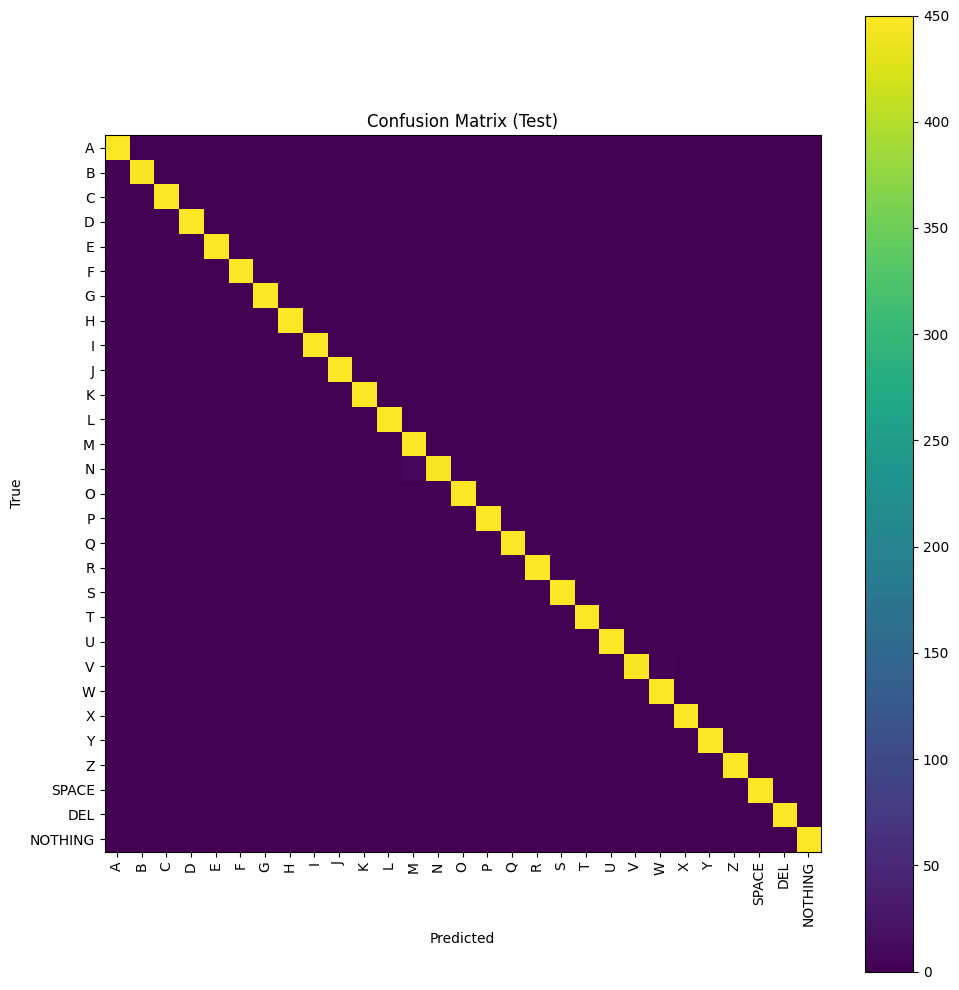

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np, matplotlib.pyplot as plt

CLASSES = ['A','B','C','D','E','F','G','H','I','J','K','L','M',
           'N','O','P','Q','R','S','T','U','V','W','X','Y','Z','SPACE','DEL','NOTHING']

y_true, y_pred = [], []
for xb, yb in test_ds:
    probs = best.predict(xb, verbose=0)
    y_pred.append(np.argmax(probs, axis=1))
    y_true.append(yb.numpy())
y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix (Test)')
plt.colorbar(); ticks = np.arange(len(CLASSES))
plt.xticks(ticks, CLASSES, rotation=90); plt.yticks(ticks, CLASSES)
plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()
